In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re

##  1. Load data and build a model

In [2]:
train = pd.read_csv("data/train.csv")
test  = pd.read_csv("data/test.csv")
X_y_train = xgb.DMatrix(data=train[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], label= train['Survived'])
X_test    = xgb.DMatrix(data=test[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']])

In [3]:
train[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch', 'Survived']].head()

,Pclass,Age,Fare,SibSp,Parch,Survived
0,3,22.0,7.2500,1,0,0
1,1,38.0,71.2833,1,0,1
2,3,26.0,7.9250,0,0,1
3,1,35.0,53.1000,1,0,1
4,3,35.0,8.0500,0,0,0


In [4]:
params = {
          'base_score': np.mean(train['Survived']),
          'eta':  0.1,
          'max_depth': 3,
          'gamma' :3,
          'objective'   :'reg:linear',
          'eval_metric' :'mae'
         }
model = xgb.train(params=params, 
                  dtrain=X_y_train, 
                  num_boost_round=3)

### visualization of model (need to install graphviz in order to use this feature)

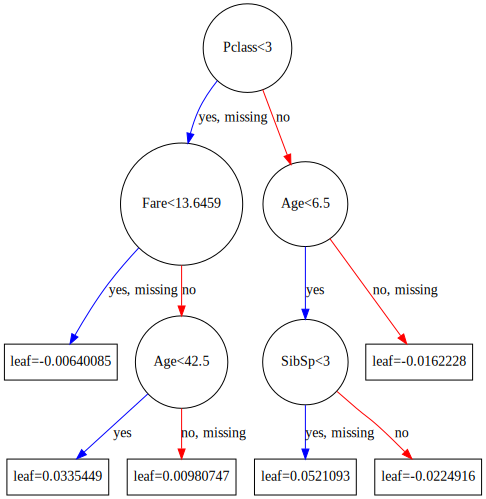

In [5]:
xgb.to_graphviz(booster = model, num_trees=0)

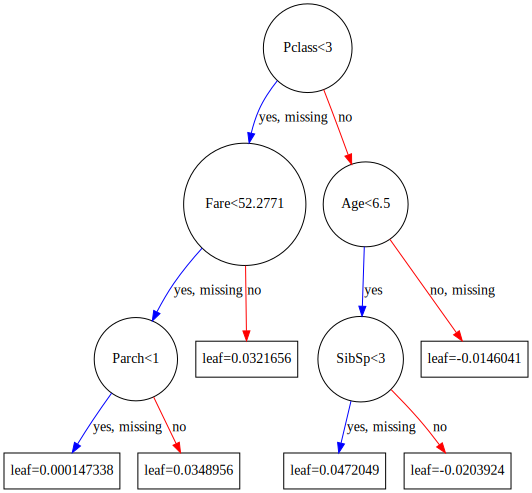

In [6]:
xgb.to_graphviz(booster = model, num_trees=1)

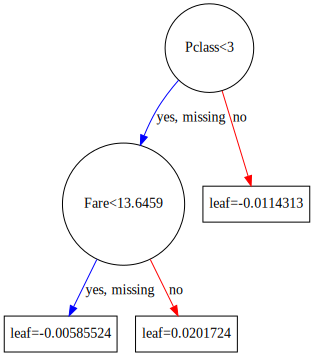

In [7]:
xgb.to_graphviz(booster = model, num_trees=2)

In [8]:
model.get_dump()

['0:[Pclass<3] yes=1,no=2,missing=1\n\t1:[Fare<13.6459] yes=3,no=4,missing=3\n\t\t3:leaf=-0.00640085\n\t\t4:[Age<42.5] yes=9,no=10,missing=10\n\t\t\t9:leaf=0.0335449\n\t\t\t10:leaf=0.00980747\n\t2:[Age<6.5] yes=5,no=6,missing=6\n\t\t5:[SibSp<3] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.0521093\n\t\t\t12:leaf=-0.0224916\n\t\t6:leaf=-0.0162228\n',
 '0:[Pclass<3] yes=1,no=2,missing=1\n\t1:[Fare<52.2771] yes=3,no=4,missing=3\n\t\t3:[Parch<1] yes=7,no=8,missing=7\n\t\t\t7:leaf=0.000147338\n\t\t\t8:leaf=0.0348956\n\t\t4:leaf=0.0321656\n\t2:[Age<6.5] yes=5,no=6,missing=6\n\t\t5:[SibSp<3] yes=11,no=12,missing=11\n\t\t\t11:leaf=0.0472049\n\t\t\t12:leaf=-0.0203924\n\t\t6:leaf=-0.0146041\n',
 '0:[Pclass<3] yes=1,no=2,missing=1\n\t1:[Fare<13.6459] yes=3,no=4,missing=3\n\t\t3:leaf=-0.00585524\n\t\t4:leaf=0.0201724\n\t2:leaf=-0.0114313\n']

### convert dump string to .py file 

In [9]:
def string_parser(s):
    if len(re.findall(r":leaf=", s)) == 0:
        out  = re.findall(r"[\w.-]+", s)
        tabs = re.findall(r"[\t]+", s)
        if (out[4] == out[8]):
            missing_value_handling = (" or np.isnan(x['" + out[1] + "']) ")
        else:
            missing_value_handling = ""
            
        if len(tabs) > 0:
            return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                    '        if state == ' + out[0] + ':\n' +
                    re.findall(r"[\t]+", s)[0].replace('\t', '    ') +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling + 
                    ' else ' + out[6] + ')\n' )
        
        else:
            return ('        if state == ' + out[0] + ':\n' +
                    '            state = (' + out[4] +  
                    ' if ' +  "x['" + out[1] +"']<" + out[2] + missing_value_handling +
                    ' else ' + out[6] + ')\n' )
    else:
        out = re.findall(r"[\d.-]+", s)
        return (re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        if state == ' + out[0] + ':\n    ' +
                re.findall(r"[\t]+", s)[0].replace('\t', '    ') + 
                '        return ' + out[1] + '\n')

In [10]:
def tree_parser(tree, i):
    if i == 0:
        return ('    if num_booster == 0:\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) for i in range(len(tree.split('\n'))-1)]))
    else:
        return ('    elif num_booster == '+str(i)+':\n        state = 0\n'
             + "".join([string_parser(tree.split('\n')[i]) for i in range(len(tree.split('\n'))-1)])) 
    
def model_to_py(base_score, model, out_file):
    trees = model.get_dump()
    result = ["import numpy as np\n\n" 
             +"def xgb_tree(x, num_booster):\n"]
    
    for i in range(len(trees)):
        result.append(tree_parser(trees[i], i))
    
    with open(out_file, 'a') as the_file:
        the_file.write("".join(result) + "\ndef xgb_predict(x):\n    predict = " + str(base_score) + "\n"
                 + "# initialize prediction with base score\n" 
                 + "    for i in range(" 
                 + str(len(trees))  
                 + "):\n        predict = predict + xgb_tree(x, i)"
                 + "\n    return predict")

In [14]:
model_to_py(params['base_score'], model, 'xgb_model.py')

### prediction using dump file

In [15]:
import xgb_model

passenger_data_1 = {'Pclass':3, 'Age':np.nan, 'SibSp':0, 'Parch':0, 'Fare':7.8958}
passenger_data_2 = {'Pclass':1, 'Age':46, 'SibSp':0, 'Parch':0, 'Fare':26}

print(xgb_model.xgb_predict(passenger_data_1))
print(xgb_model.xgb_predict(passenger_data_2))

0.34158018383838384
0.4139655918383838


In [16]:
y_test=  model.predict(X_test)   
test['pred'] = y_test
test[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch','pred']].iloc[10:].head(2)

,Pclass,Age,Fare,SibSp,Parch,pred
10,3,NaN,7.8958,0,0,0.341580
11,1,46.0,26.0000,0,0,0.413966
